# Environment setup

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3505, done.
remote: Counting objects: 100% (3505/3505), done.
remote: Compressing objects: 100% (2925/2925), done.
remote: Total 3505 (delta 913), reused 1422 (delta 527), pack-reused 0
Receiving objects: 100% (3505/3505), 46.99 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (913/913), done.


In [ ]:
# Install the Object Detection API
# %%bash
# cd models/research/
# protoc object_detection/protos/*.proto --python_out=.
# cp object_detection/packages/tf1/setup.py .
# python -m pip install .

# Download the model weights
# if not pathlib.Path('shoeDetection').exists():
#   !git clone --depth 1 https://github.com/ibaiGorordo/shoeDetection.git

## Import libraries

In [4]:
import os
import cv2
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import sys
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

2022-10-25 11:21:47.235319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 11:21:47.706130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rik/.local/lib/python3.8/site-packages/cv2/../../lib64::/usr/local/lib
2022-10-25 11:21:47.706177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-25 11:21:47.781391: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

## Define helper functions

In [47]:
def findRange(box):
    # Coords in {TopDist, LeftDist, BotDist, RightDist}
    # Returns a value between -1 and 1 for left and right
    leftDist = box['box'][1]
    rightDist = box['box'][3]
    avg = (rightDist - leftDist) / 2 + (leftDist)
    return avg * 2 - 1
    
def reduceBoxes(boxes, scores, classes):
    '''Function to reduce all the boxes to only the ones being displayed.
    Slightly modified version of Shreyas Vedpathak's version from stackoverflow:
    https://stackoverflow.com/a/68376832/19442761'''
    
    max_boxes_to_draw = boxes.shape[0]
    min_score_thresh=.5
    
    # Loop over all objects
    coordinates = []
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores[i] > min_score_thresh:
            class_id = int(classes[0][i] + 1)
            coordinates.append({
                "box": boxes[i],
                "score": scores[i]
            })

    return coordinates

def cropImg(image, box):
    # box in {TopDist, LeftDist, BotDist, RightDist}, in ratios
    # left, upper, right, and lower
    PIL_image = Image.fromarray(np.uint8(image)).convert('RGB')
    siz = PIL_image.size
    hwhw = np.tile(siz, 2).flatten()

    # Cropping as left, upper, right, and lower
    newbox = np.array([box[1], box[0], box[3], box[2]])

    imgcoords = hwhw * newbox
    
    print(hwhw)
    print(newbox)
    print(imgcoords)
    
    return PIL_image.crop(imgcoords)

# Setting up and loading the model

In [48]:
%matplotlib inline

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = 'weights/frozen_inference_graph.pb'

# Path to label map file
PATH_TO_LABELS = 'weights/label_map.pbtxt'

# Path to image
PATH_TO_IMAGE_FOLDER = 'images/'

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')


# Running the actual classification

[800 531 800 531]
[0.4770978  0.36382252 0.7383793  0.70503753]
[381.67824745 193.189758   590.70343971 374.37493068]


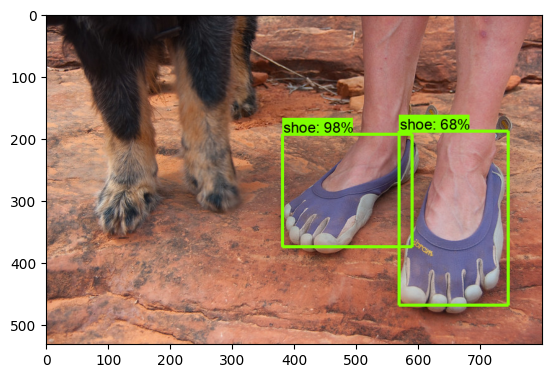

In [50]:
# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value

for filename in os.listdir(PATH_TO_IMAGE_FOLDER):
    if filename.endswith(".jpg"):
        image_read = cv2.imread(os.path.join(PATH_TO_IMAGE_FOLDER, filename))
        image = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
        image_expanded = np.expand_dims(image, axis=0)
        
        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_expanded})

        coords = reduceBoxes(boxes[0], scores[0], classes)
        cropImg(image, coords[0]['box']).show()
        
        # Draw the results of the detection (aka 'visulaize the results')
        vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=5,
            min_score_thresh=0.50)

        # All the results have been drawn on image. Now display the image.
        plt.imshow(image)        